#### Copyright 2018 Google LLC.

In [46]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification
## Exercise 2: Reducing Overfitting
**_Estimated completion time: 30 minutes_**

In this notebook we will build on the model we created in Exercise 1 to classify cats vs. dogs, and improve accuracy by employing a couple strategies to reduce overfitting: **data augmentation** and **dropout**. 

We will follow these steps:

1. Explore how data augmentation works by making random transformations to training images.
2. Add data augmentation to our data preprocessing.
3. Add dropout to the convnet.
4. Retrain the model and evaluate loss and accuracy. 

Let's get started!

## Exploring Data Augmentation

Let's get familiar with the concept of **data augmentation**, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, **our model will never see the exact same picture twice**. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation](https://keras.io/preprocessing/image/). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images. First let's set up our example files, as in Exercise 1.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [0]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

In [129]:
import cv2
import numpy as np
#import imgaug as ia
#import imgaug.augmenters as iaa
import os,glob

images = glob.glob("/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered/train/cats/*.jpg")



angle90 = 90
angle180 = 180
angle270 = 270

scale = 1.0


for i, im in enumerate(images):
    imr = cv2.imread(im)
    #imr = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB) #  IF RGB NOT LABELS
    img = imr.copy()
    (h, w) = img.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle90, scale)
    rotated90 = cv2.warpAffine(img, M, (h, w))
    #rotated90 = cv2.cvtColor(rotated90, cv2.COLOR_BGR2RGB)
    cv2.imwrite(im[:-4]+'_rotate90.jpg', rotated90)
    img = imr.copy()
    (h, w) = img.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle180, scale)
    rotated180 = cv2.warpAffine(img, M, (h, w))
    #rotated180 = cv2.cvtColor(rotated180, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(im[:-4]+'_rotate180.jpg', rotated180)
    img = imr.copy()
    (h, w) = img.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle270, scale)
    rotated270 = cv2.warpAffine(img, M, (h, w))
    #rotated270 = cv2.cvtColor(rotated270, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(im[:-4]+'_rotate270.jpg', rotated270)
    img = imr.copy()
    horizontal_img = cv2.flip( img, 0 )
    vertical_img = cv2.flip( img, 1 )
    #horizontal_img = cv2.cvtColor(horizontal_img, cv2.COLOR_BGR2RGB)
    #vertical_img = cv2.cvtColor(vertical_img, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(im[:-4]+'_horizontal_flip.jpg', horizontal_img)
    #cv2.imwrite(im[:-4]+'_vertical_flip.jpg', vertical_img)

In [145]:
import os
import zipfile

"""local_zip = '/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()"""
  
base_dir = '/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

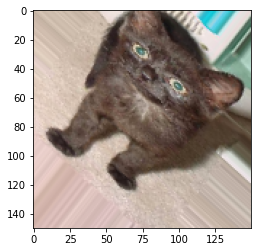

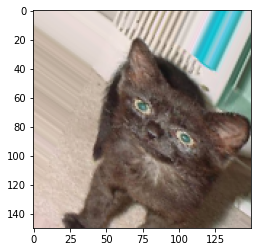

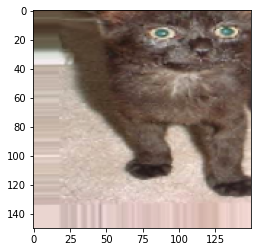

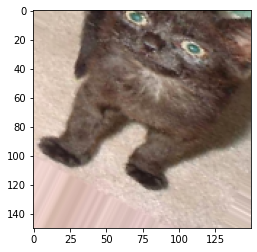

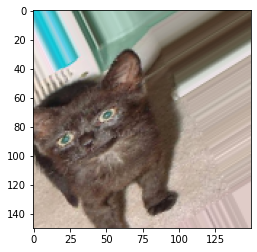

In [146]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Add Data Augmentation to the Preprocessing Step

Now let's add our data-augmentation transformations from [**Exploring Data Augmentation**](#scrollTo=E3sSwzshfSpE) to our data preprocessing configuration:

In [147]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1501 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

## Adding Dropout

Another popular strategy for fighting overfitting is to use **dropout**.

**TIP:** To learn more about dropout, see [Training Neural Networks](https://developers.google.com/machine-learning/crash-course/training-neural-networks/video-lecture) in [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

Let's reconfigure our convnet architecture from Exercise 1 to add some dropout, right before the final classification layer:

In [159]:
# Define metrics to use
from tensorflow.keras import metrics

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='acc'),
]


In [149]:
ls /Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered/train/cats/ | wc -l

     501


In [150]:
import glob
cats, dogs = len(glob.glob('/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered/train/cats/*')), len(glob.glob('/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered/train/dogs/*'))
total = cats + dogs

In [151]:
cats, dogs

(501, 1000)

In [152]:
initial_bias = np.log([cats/dogs])
initial_bias

array([-0.69114918])

In [153]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / cats)*(total)/2.0 
weight_for_1 = (1 / dogs)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.50
Weight for class 1: 0.75


In [154]:
print('Examples:\n    Total: {}\n    Cats: {} ({:.2f}% of total)\n'.format(
    total, cats, 100 * cats / total))

Examples:
    Total: 1501
    Cats: 501 (33.38% of total)



In [155]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import Constant

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output_bias = Constant(initial_bias)
output = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
#output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=METRICS)
              #metrics=['acc'])

In [156]:
from tensorflow.keras import callbacks

checkpoint_path = "/Users/lilliannethomas/Desktop/notebooks/workspace/cats_and_dogs_filtered/training_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=1,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

## Retrain the Model

With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.) See if you can write the code yourself:


In [142]:
# WRITE CODE TO TRAIN THE MODEL ON ALL 2000 IMAGES FOR 30 EPOCHS, AND VALIDATE 
# ON ALL 1,000 VALIDATION IMAGES

### Solution

Click below for the solution.

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
history = model.fit_generator(
      train_generator,
      #steps_per_epoch=100,
      steps_per_epoch=50,
      epochs=10,
      #epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      class_weight=class_weight,
      callbacks=[cp_callback],
      verbose=2)

Class weights, no initial bias: 50/50 - 624s - loss: 0.6234 - tp: 392.0000 - fp: 94.0000 - tn: 237.0000 - fn: 258.0000 - accuracy: 0.6412 - precision: 0.8066 - recall: 0.6031 - auc: 0.7108 - val_loss: 0.6642 - val_tp: 326.0000 - val_fp: 148.0000 - val_tn: 352.0000 - val_fn: 174.0000 - val_accuracy: 0.6780 - val_precision: 0.6878 - val_recall: 0.6520 - val_auc: 0.7618

Class weights, initial bias:  50/50 - 58s - loss: 0.6322 - tp: 418.0000 - fp: 99.0000 - tn: 225.0000 - fn: 258.0000 - accuracy: 0.6430 - precision: 0.8085 - recall: 0.6183 - auc: 0.6993 - val_loss: 0.6883 - val_tp: 351.0000 - val_fp: 153.0000 - val_tn: 347.0000 - val_fn: 149.0000 - val_accuracy: 0.6980 - val_precision: 0.6964 - val_recall: 0.7020 - val_auc: 0.7701

90 degree rotation on underrep class, Class weights, initial bias: 50/50 - 49s - loss: 0.5014 - tp: 481.0000 - fp: 214.0000 - tn: 267.0000 - fn: 38.0000 - accuracy: 0.7480 - precision: 0.6921 - recall: 0.9268 - auc: 0.8048 - val_loss: 0.6880 - val_tp: 476.0000 - val_fp: 410.0000 - val_tn: 90.0000 - val_fn: 24.0000 - val_accuracy: 0.5660 - val_precision: 0.5372 - val_recall: 0.9520 - val_auc: 0.7232

Class weights, initial bias, no dropout: 50/50 - 93s - loss: 0.6164 - tp: 387.0000 - fp: 82.0000 - tn: 247.0000 - fn: 284.0000 - accuracy: 0.6340 - precision: 0.8252 - recall: 0.5768 - auc: 0.7226 - val_loss: 1.9608 - val_tp: 492.0000 - val_fp: 451.0000 - val_tn: 49.0000 - val_fn: 8.0000 - val_accuracy: 0.5410 - val_precision: 0.5217 - val_recall: 0.9840 - val_auc: 0.7565

Note that with data augmentation in place, the 2,000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

In [158]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

KeyError: 'acc'

Much better! We are no longer overfitting, and we have gained ~3 validation accuracy percentage points (see the green line in the top chart). In fact, judging by our training profile, we could keep fitting our model for 30+ more epochs and we could probably get to ~80%!

In [161]:
train_predictions_baseline = model.predict_generator(train_generator)
test_predictions_baseline = model.predict_generator(validation_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [168]:
len(test_predictions_baseline)

1000

In [163]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
# NOT READY

test_labels = ['cats', 'dogs']

baseline_results = model.evaluate(validation_generator, test_labels, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)